In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

In [16]:
from dispatches.case_studies.renewables_case.double_loop_utils import double_loop_outputs_for_gen, prescient_outputs_for_gen
from dispatches_sample_data import rts_gmlc

double_loop_dir = "/projects/gmihybridsys/dguittet/dispatches/double_loop_parametrized_results_week_verbose"
dl_df = double_loop_outputs_for_gen(double_loop_dir, rts_gmlc.source_data_path)

In [26]:
res = dl_df[dl_df['Model'] == "Prescient"]
res = res.dropna(axis=1)

def calc_rev(res):
    res["Revenue"] = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).values
    res["Revenue DA"] = (res["Dispatch DA"] * res["LMP DA"]).values
    return res

res = calc_rev(res)

# Analysis of Wind + PEM System for 1st week

- 847 MW wind
- 127.05 MW pem
- 15 $/MWh
- 0.15 reservers
- 1000 shortfall price

## Prescient Sweep Results

In [39]:
# old original sweep dir
sweep_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/results_parameter_sweep_15_1000/sweep_results_index_0.csv"
sw_df = pd.read_csv(sweep_dir)
sw_df = calc_rev(sw_df)
sw_df = sw_df[:len(dl_df.index.unique())]
sw_df.index = dl_df.index.unique()
sw_df.describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,223.648507,6.764453,217.439260,11.805368,2246.159668,2299.549067
std,217.855549,15.582552,204.082942,20.614352,5084.376382,5060.858344
min,0.000000,-0.000000,0.000000,-0.000000,-6183.168398,-0.000000
25%,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
50%,138.021693,-0.000000,168.575000,-0.000000,-0.000000,-0.000000
75%,465.384696,15.000000,445.679175,19.133655,1737.623025,2117.672821
max,616.126055,121.843654,561.227559,94.066686,30071.248736,31032.599711


In [51]:
# verbose sweep dir
sweep_week_dir = "/projects/gmihybridsys/bknueven/software/dispatches/parameter_sweep_15_1000_index_0"
sww_df = prescient_outputs_for_gen(sweep_week_dir, rts_gmlc.source_data_path, '303_WIND_1')
sww_df = sww_df.rename(columns={
    "Output": "Dispatch", "Output DA": "Dispatch DA"
})
sww_df = calc_rev(sww_df)
sww_df[cols].describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,217.092775,8.457893,179.480792,11.808150,1109.147931,1201.883819
std,225.288191,21.355145,209.476840,20.581767,3474.439430,3275.428065
min,0.000000,-0.000000,0.000000,-0.000000,-8093.014332,-0.000000
25%,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
50%,131.764794,-0.000000,35.250000,-0.000000,-0.000000,-0.000000
75%,453.602219,15.000000,417.050000,19.133655,0.000000,0.000000
max,606.470729,127.050889,596.595910,94.066686,18955.427255,19081.427255


## Double Loop Results

from `run_double_loop_PEM.py`

In [28]:
cols = [c for c in sw_df.columns if c in res.columns]
res[cols].describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,230.220100,14.024121,261.169955,14.372682,3459.310531,3528.109259
std,228.086155,29.773723,199.237535,21.624658,8290.588854,6863.505888
min,0.000000,-0.000000,0.000000,-0.000000,-43372.988417,-0.000000
25%,0.000000,0.000000,80.200000,0.000000,0.000000,0.000000
50%,118.441896,-0.000000,205.725000,0.000000,-0.000000,-0.000000
75%,483.910155,19.133655,481.462907,20.404777,3779.265339,4394.728701
max,595.963929,126.324557,649.450000,93.822179,34075.027122,33067.655948


## Plot Differences

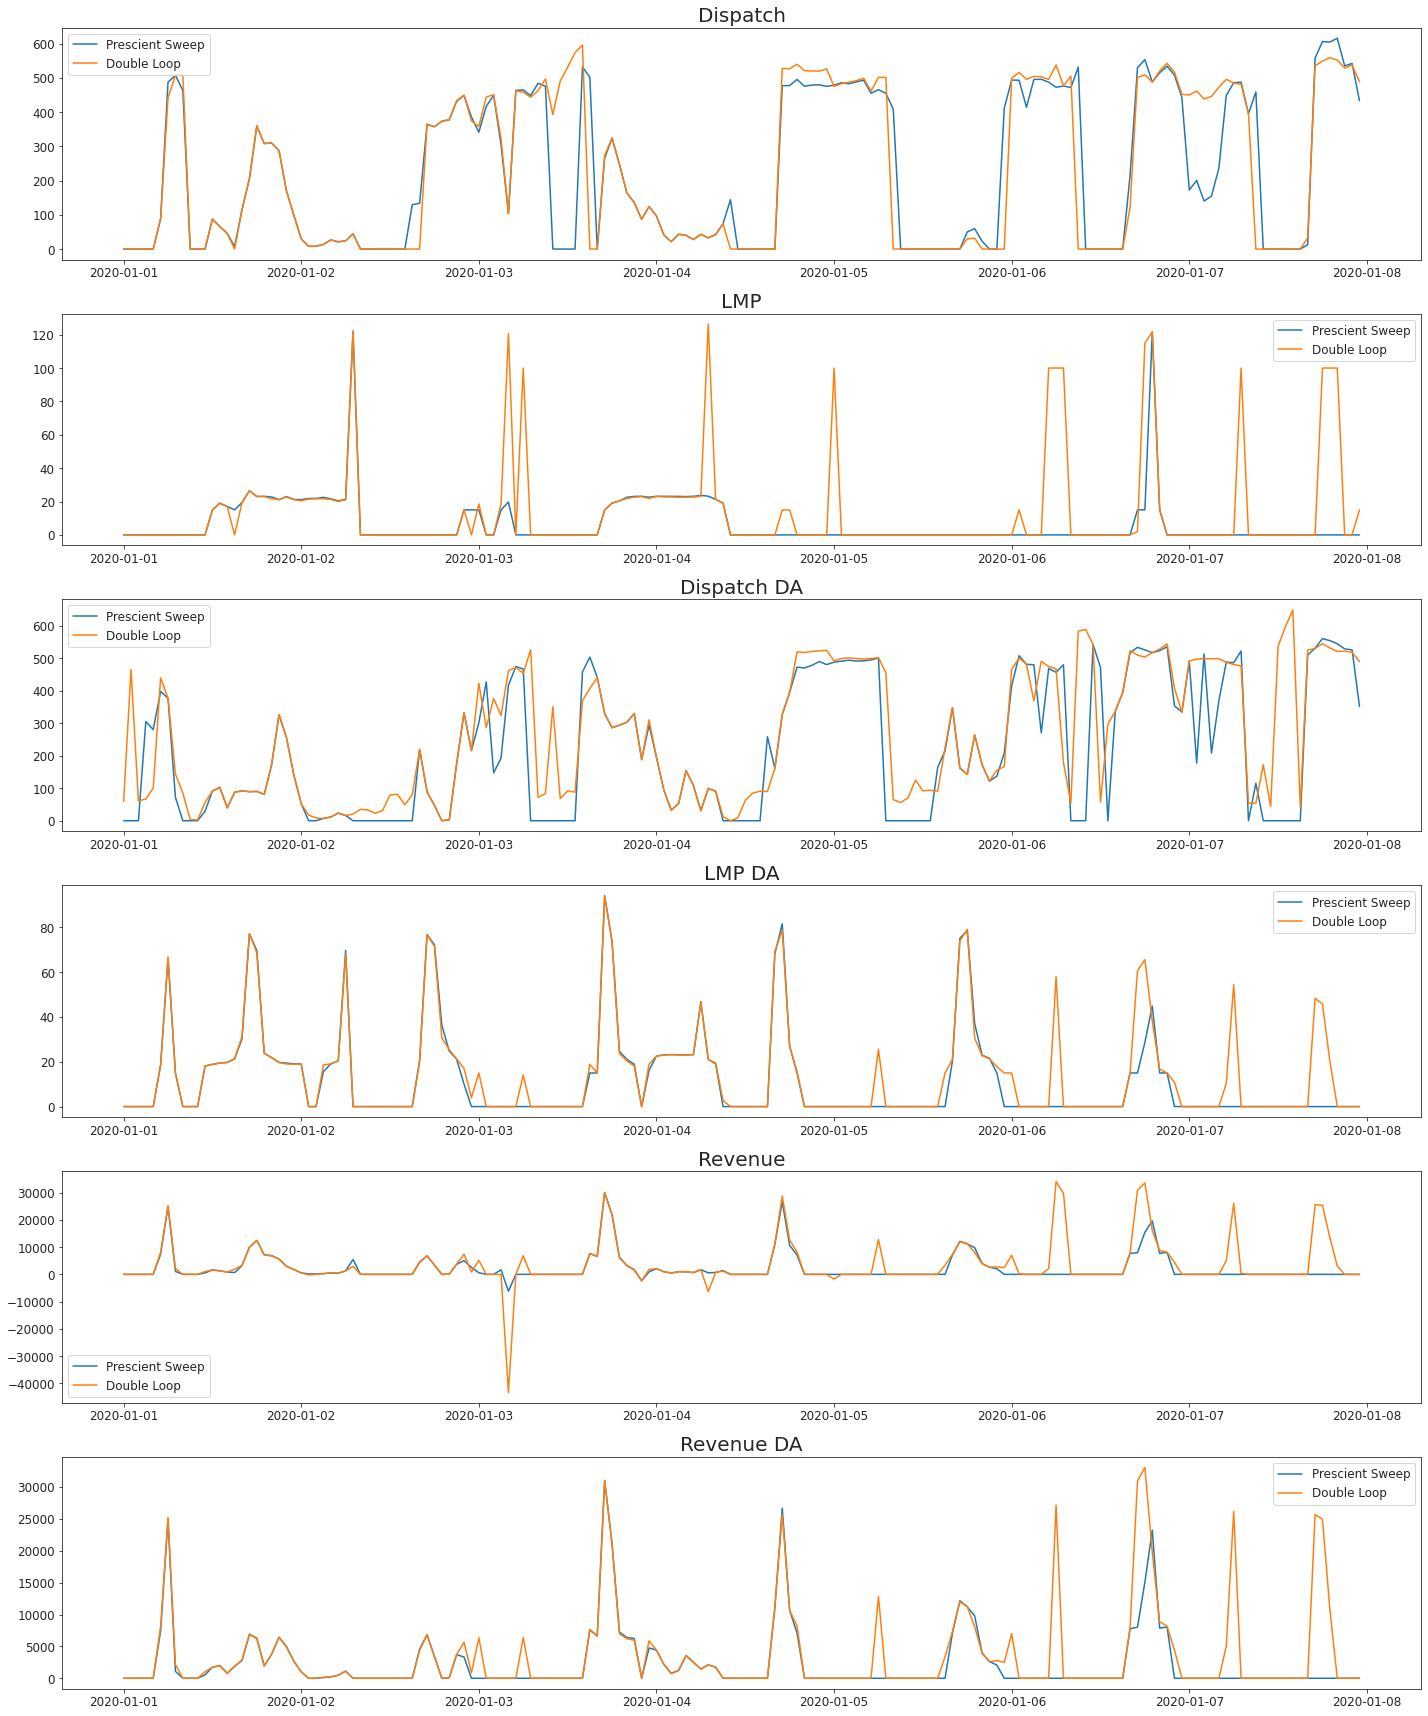

In [57]:
# Difference between annual Prescient sweep and double loop
fig, ax = plt.subplots(len(cols), 1, figsize=(20, 4 * len(cols)))
for i, c in enumerate(cols):
    ax[i].plot(sw_df[c], label="Prescient Sweep")
    ax[i].plot(res[c], label="Double Loop")
    ax[i].set_title(c)
    ax[i].legend()
fig.tight_layout()

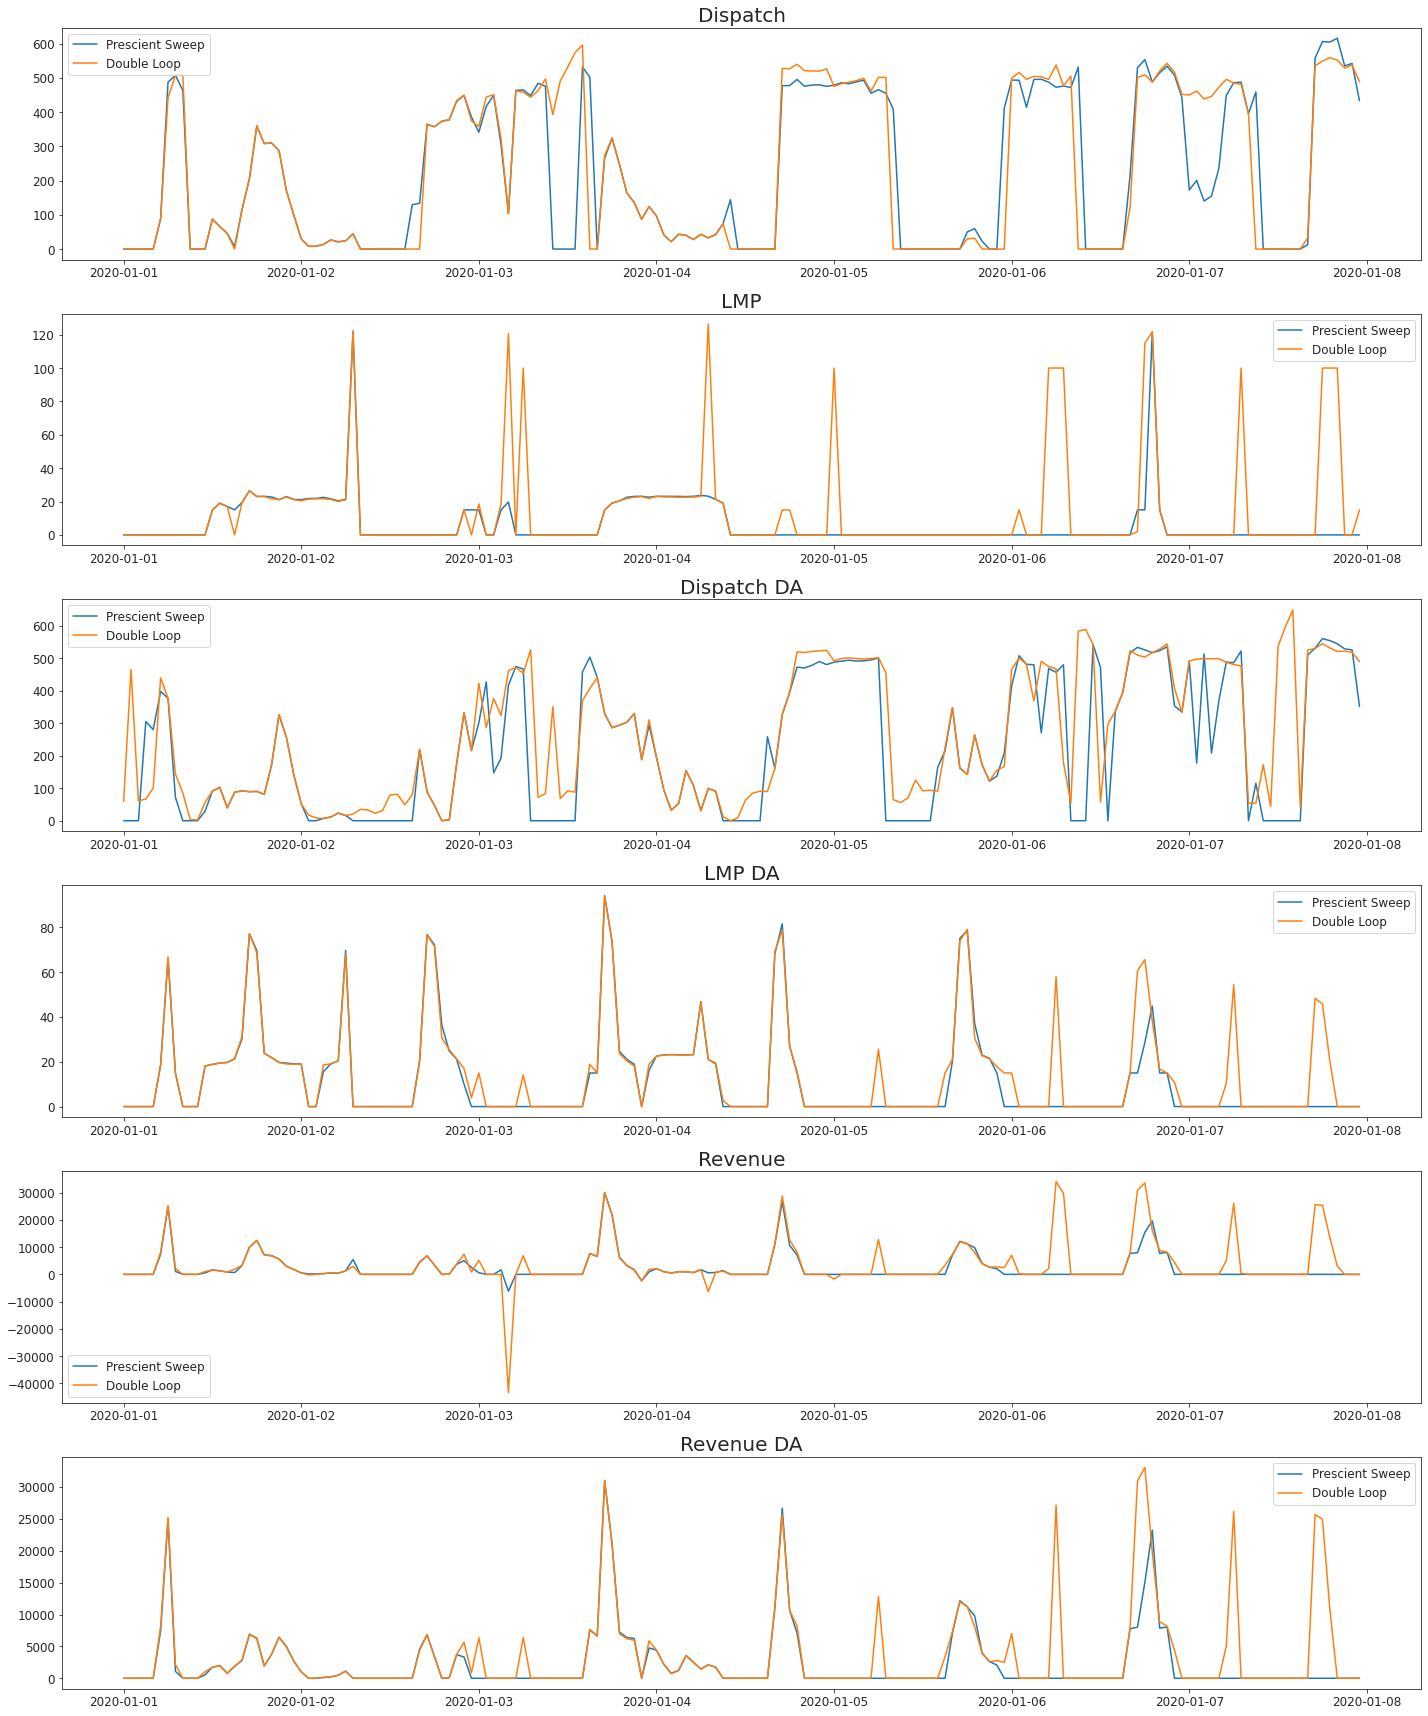

In [56]:
# Difference between week Prescient sweep and double loop
fig, ax = plt.subplots(len(cols), 1, figsize=(20, 4 * len(cols)))
for i, c in enumerate(cols):
    ax[i].plot(sw_df[c], label="Prescient Sweep")
    ax[i].plot(res[c], label="Double Loop")
    ax[i].set_title(c)
    ax[i].legend()
fig.tight_layout()

In [38]:
(sw_df['Revenue DA'] - res['Revenue DA']).values
sw_df[["Dispatch DA", "LMP DA"]].head(10)

,Dispatch DA,LMP DA
Datetime,,
2020-01-01 00:00:00,0.000000,-0.000000
2020-01-01 01:00:00,0.000000,-0.000000
2020-01-01 02:00:00,0.000000,-0.000000
2020-01-01 03:00:00,305.650000,-0.000000
2020-01-01 04:00:00,280.850000,-0.000000
2020-01-01 05:00:00,398.711107,18.573789
2020-01-01 06:00:00,377.300000,66.197376
2020-01-01 07:00:00,72.250000,15.000000
2020-01-01 08:00:00,0.000000,-0.000000


In [32]:
res[["Dispatch DA", "LMP DA"]].head(10)

,Dispatch DA,LMP DA
Datetime,,
2020-01-01 00:00:00,59.000000,-0.000000
2020-01-01 01:00:00,466.000366,-0.000000
2020-01-01 02:00:00,61.000000,-0.000000
2020-01-01 03:00:00,67.000000,-0.000000
2020-01-01 04:00:00,100.558433,-0.000000
2020-01-01 05:00:00,440.200000,18.573789
2020-01-01 06:00:00,377.300000,66.769371
2020-01-01 07:00:00,143.959406,15.000000
2020-01-01 08:00:00,85.400000,-0.000000
